In [1]:
import cv2
import glob
import numpy as np
import pandas as pd

from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2

from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
image_path = glob.glob("train/*/*")
labels = [x.split("/")[-2] for x in image_path]

le = LabelEncoder()
lb = LabelBinarizer()

labels = le.fit_transform(labels)
y = lb.fit_transform(labels)

target_names = le.classes_
print(y.shape)
print(target_names)

(4750, 12)
['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [3]:
X = []
for i in image_path:
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    X.append(img)
    
X = np.array(X).astype(np.float32)

print(X.shape)
print(X.nbytes/(1024000))

(4750, 224, 224, 3)
2793.0


In [4]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=200, random_state=4750)
Xtr, Xval, ytr, yval = train_test_split(Xtr, ytr, test_size=200, random_state=4750)

In [5]:
mean = np.mean(Xtr, axis=0)

Xtr -= mean
Xval -= mean
Xte -= mean

In [6]:
for i in [ytr, yval, yte]:
    temp = le.inverse_transform(lb.inverse_transform(i))
    a, b = np.unique(temp, return_counts=True)
    df = pd.DataFrame({"label": a, "count": b})
    print(df)
    print(" ")
    
del temp, a, b, df

                        label  count
0                 Black-grass    244
1                    Charlock    369
2                    Cleavers    261
3            Common Chickweed    548
4                Common wheat    202
5                     Fat Hen    427
6            Loose Silky-bent    600
7                       Maize    202
8           Scentless Mayweed    478
9             Shepherds Purse    215
10  Small-flowered Cranesbill    450
11                 Sugar beet    354
 
                        label  count
0                 Black-grass      8
1                    Charlock      9
2                    Cleavers     18
3            Common Chickweed     35
4                Common wheat     10
5                     Fat Hen     28
6            Loose Silky-bent     22
7                       Maize      9
8           Scentless Mayweed     23
9             Shepherds Purse      9
10  Small-flowered Cranesbill     19
11                 Sugar beet     10
 
                        label  cou

/home/yq/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/yq/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/yq/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Building the network

In [7]:
# implementation based on @pyimagesearch
class ResNet:
    def __init__(self, width, height, channels, classes, stages, filters, reg=0.0001, 
                 bnEps=2e-5, bnMom=0.9):
        self.width = width
        self.height = height
        self.channels = channels
        self.classes = classes
        self.stages = stages
        self.filters = filters
        self.reg = reg
        self.bnEps = bnEps
        self.bnMom = bnMom
        
    def residual_module(self, x, K, stride, reduce=False, reg=0.0001, bnEps=2e-5, bnMom=0.9):
        shortcut = x
        
        bn1 = BatchNormalization(axis=-1, epsilon=bnEps, momentum=bnMom)(x)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K*0.25), 1, use_bias=False, kernel_regularizer=l2(reg))(act1)
        
        bn2 = BatchNormalization(axis=-1, epsilon=bnEps, momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K*0.25), 3, strides=stride, padding="same", use_bias=False, 
                       kernel_regularizer=l2(reg))(act2)
        
        bn3 = BatchNormalization(axis=-1, epsilon=bnEps, momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, 1, use_bias=False, kernel_regularizer=l2(reg))(act3)
        
        if reduce:
            shortcut = Conv2D(K, 1, strides=stride, use_bias=False, 
                             kernel_regularizer=l2(reg))(act1)
            
        out = add([conv3, shortcut])
        
        return out
    
    def build(self):
        input_shape = (self.height, self.width, self.channels)
        
        inputs = Input(shape=input_shape)
        x = BatchNormalization(axis=-1, epsilon=self.bnEps, momentum=self.bnMom)(inputs)
        x = Conv2D(self.filters[0], 7, strides=2, use_bias=False, padding="same", 
                   kernel_regularizer=l2(self.reg))(x)
        x = BatchNormalization(axis=-1, epsilon=self.bnEps, momentum=self.bnMom)(x)
        x = Activation("relu")(x)
        x = ZeroPadding2D(1)(x)
        x = MaxPooling2D((3, 3), strides=2)(x)
        
        for i in range(0, len(self.stages)):
            stride = 1 if i==0 else 2
            x = self.residual_module(x, self.filters[i+1], stride, reduce=True,
                                    bnEps=self.bnEps, bnMom=self.bnMom)
            
            for j in range(0, self.stages[i]-1):
                x = self.residual_module(x, self.filters[i+1], 1, bnEps=self.bnEps,
                                         bnMom=self.bnMom)
            
        # after 4 stages, a 224x224 image will be 7x7 at this point
        # use average pooling to reduce to 1x1xclasses
        x = BatchNormalization(axis=-1, epsilon=self.bnEps, momentum=self.bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D(7)(x)
        
        x = Flatten()(x)
        x = Dense(self.classes, kernel_regularizer=l2(self.reg))(x)
        x = Activation("softmax")(x)
        
        model = Model(inputs, x, name="resnet")
        
        return model

In [8]:
#(3,5,5,3), (32,64,64,128,256)
res = ResNet(224, 224, 3, 12, (3,5,5,5), (32, 64, 128, 128, 256), reg=0.0005)
model = res.build()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 32) 4704        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 112, 112, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

## Training

In [9]:
BS = 64
epochs = 170
lr = 1e-1

In [10]:
def poly_decay(epoch):
    alpha = lr * (1 - (epoch/float(epochs))) ** 1.0
    
    return alpha

In [11]:
aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.2, horizontal_flip=True,
                        vertical_flip=True, rotation_range=25, fill_mode="nearest")

callbacks = [TensorBoard(log_dir="logs", batch_size=BS), LearningRateScheduler(poly_decay)]
opt = SGD(lr=lr)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [12]:
model.fit_generator(aug.flow(Xtr, ytr, batch_size=BS), validation_data=(Xval, yval),
                   steps_per_epoch=len(Xtr)//BS, epochs=epochs, callbacks=callbacks)

Epoch 1/170
67/67 [==============================] - 27s 401ms/step - loss: 2.4874 - acc: 0.2657 - val_loss: 2.1695 - val_acc: 0.3750
Epoch 2/170
67/67 [==============================] - 24s 364ms/step - loss: 1.7820 - acc: 0.5220 - val_loss: 1.8865 - val_acc: 0.4550
Epoch 3/170
67/67 [==============================] - 24s 362ms/step - loss: 1.5133 - acc: 0.6085 - val_loss: 1.5427 - val_acc: 0.6000
Epoch 4/170
67/67 [==============================] - 24s 360ms/step - loss: 1.3631 - acc: 0.6566 - val_loss: 1.4378 - val_acc: 0.6300
Epoch 5/170
67/67 [==============================] - 24s 358ms/step - loss: 1.2238 - acc: 0.7014 - val_loss: 1.0526 - val_acc: 0.7550
Epoch 6/170
67/67 [==============================] - 24s 355ms/step - loss: 1.1149 - acc: 0.7375 - val_loss: 1.2223 - val_acc: 0.6900
Epoch 7/170
67/67 [==============================] - 24s 357ms/step - loss: 1.0458 - acc: 0.7646 - val_loss: 1.1122 - val_acc: 0.7850
Epoch 8/170
67/67 [==============================] - 24s 357ms

Epoch 62/170
67/67 [==============================] - 24s 355ms/step - loss: 0.4248 - acc: 0.9664 - val_loss: 0.4258 - val_acc: 0.9550
Epoch 63/170
67/67 [==============================] - 24s 355ms/step - loss: 0.4161 - acc: 0.9704 - val_loss: 0.4727 - val_acc: 0.9550
Epoch 64/170
67/67 [==============================] - 24s 356ms/step - loss: 0.4266 - acc: 0.9659 - val_loss: 0.5157 - val_acc: 0.9250
Epoch 65/170
67/67 [==============================] - 24s 356ms/step - loss: 0.4085 - acc: 0.9725 - val_loss: 0.4293 - val_acc: 0.9650
Epoch 66/170
67/67 [==============================] - 24s 356ms/step - loss: 0.4108 - acc: 0.9729 - val_loss: 0.4810 - val_acc: 0.9400
Epoch 67/170
67/67 [==============================] - 24s 357ms/step - loss: 0.4068 - acc: 0.9750 - val_loss: 0.4206 - val_acc: 0.9600
Epoch 68/170
67/67 [==============================] - 24s 356ms/step - loss: 0.4036 - acc: 0.9741 - val_loss: 0.4937 - val_acc: 0.9300
Epoch 69/170
67/67 [==============================] - 2

In [13]:
model.save("epoch170_resnet5.h5")

### Evaluate on test set

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from utils.cm_plot import CMPlot

In [15]:
predictions = model.predict(Xte)
predictions = np.argmax(predictions, axis=-1)
predictions.shape

(200,)

In [16]:
print(classification_report(lb.inverse_transform(yte), predictions, target_names=target_names))
print("Accuracy: {:.3f}".format(accuracy_score(lb.inverse_transform(yte), predictions)))

                           precision    recall  f1-score   support

              Black-grass       0.88      0.64      0.74        11
                 Charlock       0.92      1.00      0.96        12
                 Cleavers       1.00      1.00      1.00         8
         Common Chickweed       1.00      1.00      1.00        28
             Common wheat       1.00      1.00      1.00         9
                  Fat Hen       1.00      1.00      1.00        20
         Loose Silky-bent       0.88      0.94      0.91        32
                    Maize       1.00      1.00      1.00        10
        Scentless Mayweed       0.94      1.00      0.97        15
          Shepherds Purse       1.00      0.86      0.92         7
Small-flowered Cranesbill       1.00      1.00      1.00        27
               Sugar beet       1.00      1.00      1.00        21

              avg / total       0.96      0.96      0.96       200

Accuracy: 0.965


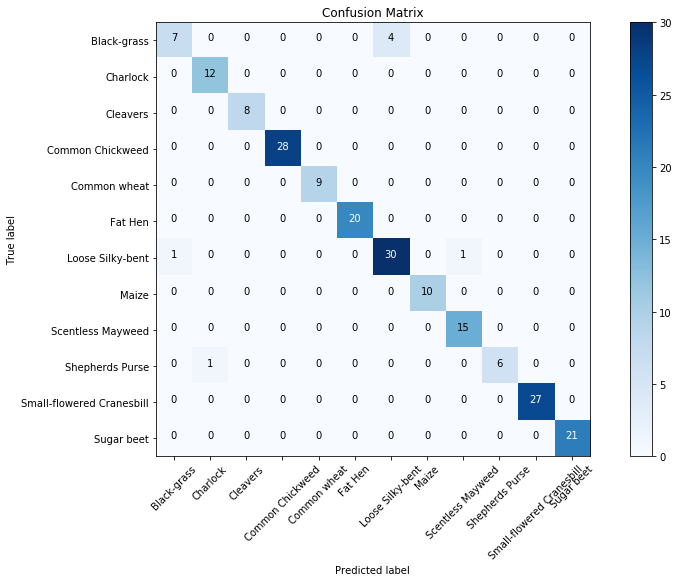

In [17]:
cm = confusion_matrix(lb.inverse_transform(yte), predictions)
CMPlot.plot(cm, classes=target_names)

### For submission

In [18]:
test_path = glob.glob("test/*")
x = []
for i in test_path:
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    x.append(img)
    
x = np.array(x).astype(np.float32)
x -= mean

print(x.shape)

(794, 224, 224, 3)


In [19]:
test_predictions = model.predict(x)
test_predictions = np.argmax(test_predictions, axis=-1)
test_predictions = le.inverse_transform(test_predictions)

/home/yq/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
df = pd.DataFrame({"file": [xx.split("/")[-1] for xx in test_path],
                  "species": test_predictions})
df.head()

,file,species
0,9c777333d.png,Common Chickweed
1,64fe8beb9.png,Scentless Mayweed
2,afcf6abd5.png,Small-flowered Cranesbill
3,41e07778c.png,Cleavers
4,8311740de.png,Fat Hen


In [21]:
df.to_csv("resnet5_submission.csv", index=False)

In [23]:
mean.shape

(224, 224, 3)

In [25]:
import pickle
pickle.dump(mean, open("mean.h5", "wb"))
pickle.dump(le, open("le.h5", "wb"))